# Load Model

In [ ]:
model_path = '/content/drive/MyDrive/ML_Datasets/Weather/temp_forecaster_model.joblib'
loaded_model = joblib.load(model_path)
print("Model loaded successfully from disk!")

Model loaded successfully from disk!


# Mount, imports and data cleaning



In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set plot style for scatterplot
plt.style.use('seaborn-v0_8-darkgrid')

# dataset file path
file_path = '/content/drive/MyDrive/ML_Datasets/Weather/hourly_data_new.csv'

# Load the data
df = pd.read_csv(file_path)

# Convert 'datetime' to a proper datetime object
df['datetime'] = pd.to_datetime(df['datetime'])

# Set 'datetime' as the index
df.set_index('datetime', inplace=True)

# Drop irrelevant or empty columns
df.drop(['city_name', 'snow_depth', 'snowfall'], axis=1, inplace=True)

# Handle missing values using forward fill
df.ffill(inplace=True)

print("Data loaded and initial cleaning is complete.")
df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded and initial cleaning is complete.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15576 entries, 2024-01-01 00:00:00 to 2025-10-10 23:00:00
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   temperature_2m                    15576 non-null  float64
 1   relative_humidity_2m              15576 non-null  float64
 2   dew_point_2m                      15576 non-null  float64
 3   apparent_temperature              15576 non-null  float64
 4   precipitation                     15576 non-null  float64
 5   rain                              15576 non-null  float64
 6   weather_code                      15576 non-null  float64
 7   pressure_msl                      15576 non-null  float64
 8   surface_pressure                  15576 non-nu

# Feature Engineering

In [ ]:
def create_features(df, target_variable):
    """
    Creates time series features from a datetime index and adds lag/rolling features.
    This version lags leaky features to prevent data leakage.
    """
    # 1. Time-based features
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24.0)
    df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24.0)
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_summer'] = (df.index.month.isin([6, 7, 8])).astype(int)

    # 2. Lag the "leaky" features BEFORE they are used
    leaky_features = [
    'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature',
    'pressure_msl', 'surface_pressure', 'vapour_pressure_deficit',
    ]
    for feature in leaky_features:
        if feature in df.columns:
            df[f'{feature}_lag_1'] = df[feature].shift(1)

    # 3. Lag features for the target variable
    for lag in [1, 3, 24]:
        df[f'{target_variable}_lag_{lag}'] = df[target_variable].shift(lag)

    # 4. Rolling window features
    df[f'{target_variable}_rolling_mean_24'] = df[target_variable].shift(1).rolling(window=24).mean()
    df[f'{target_variable}_rolling_std_24'] = df[target_variable].shift(1).rolling(window=24).std()

    # 5. Interaction Features (using LAGGED values for both)
    if 'relative_humidity_2m_lag_1' in df.columns and f'{target_variable}_lag_1' in df.columns:
        df['temp_x_humidity'] = df[f'{target_variable}_lag_1'] * df['relative_humidity_2m_lag_1']

    # 6. Drop the original leaky columns
    df = df.drop(columns=[col for col in leaky_features if col in df.columns])

    return df

# variable we want to predict
TARGET = 'temperature_2m'

df_features = create_features(df.copy(), TARGET)
df_features.dropna(inplace=True)

print("Feature engineering complete.")
print(f"Number of features: {len(df_features.columns)}")

Feature engineering complete.
Number of features: 51


# Time Series Cross-Validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import numpy as np

# Define the features (X) and the target (y)
X = df_features.drop(TARGET, axis=1)
y = df_features[TARGET]
tscv = TimeSeriesSplit(n_splits=10)

mae_scores = []

print("Running Time Series Cross-Validation (10 Folds)...")
for fold, (train_index, val_index) in enumerate(tscv.split(X)):
    X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model_cv = lgb.LGBMRegressor(
        verbosity=-1,
        objective='regression_l1',
        n_estimators=1000,
        learning_rate=0.01,
        num_leaves=4,
        min_child_samples=200,
        lambda_l1=13,
        lambda_l2=13,
        feature_fraction=0.65,
        n_jobs=-1,
        seed=42
    )

    model_cv.fit(X_train_cv, y_train_cv,
                eval_set=[(X_val_cv, y_val_cv)],
                eval_metric='l1',
                callbacks=[lgb.early_stopping(100, verbose=False)])

    preds = model_cv.predict(X_val_cv)
    mae = mean_absolute_error(y_val_cv, preds)
    mae_scores.append(mae)
    print(f"Fold {fold+1:02d} MAE: {mae:.4f}")

print("--------------------------------------")
print(f"Average MAE across all folds: {np.mean(mae_scores):.4f}")
print(f"Standard Deviation of MAE: {np.std(mae_scores):.4f}")

Running Time Series Cross-Validation (10 Folds)...
Fold 01 MAE: 1.1297
Fold 02 MAE: 0.3498
Fold 03 MAE: 0.2908
Fold 04 MAE: 0.2825
Fold 05 MAE: 0.3104
Fold 06 MAE: 0.2896
Fold 07 MAE: 0.3042
Fold 08 MAE: 0.2937
Fold 09 MAE: 0.3358
Fold 10 MAE: 0.2957
--------------------------------------
Average MAE across all folds: 0.3882
Standard Deviation of MAE: 0.2480


# **DATA SPLITTING! Train/Val/Test**

change '*split_date*' if you want

In [ ]:
# Define the features (X) and the target (y)
X = df_features.drop(TARGET, axis=1)
y = df_features[TARGET]

# Define the split points
train_end_date = '2025-05-01'
validation_end_date = '2025-08-01'

# Split the data chronologically
X_train = X.loc[X.index < train_end_date]
y_train = y.loc[y.index < train_end_date]

X_val = X.loc[(X.index >= train_end_date) & (X.index < validation_end_date)]
y_val = y.loc[(y.index >= train_end_date) & (y.index < validation_end_date)]

X_test = X.loc[X.index >= validation_end_date]
y_test = y.loc[y.index >= validation_end_date]


print(f"Training data shape:   {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape:       {X_test.shape}")

# Calculate and print percentages
total_rows = len(df_features)
train_percent = (len(X_train) / total_rows) * 100
val_percent = (len(X_val) / total_rows) * 100
test_percent = (len(X_test) / total_rows) * 100

print("\nData Split Percentages:")
print(f"Training:   {train_percent:.2f}%")
print(f"Validation: {val_percent:.2f}%")
print(f"Test:       {test_percent:.2f}%")

Training data shape:   (11640, 50)
Validation data shape: (2208, 50)
Test data shape:       (1704, 50)

Data Split Percentages:
Training:   74.85%
Validation: 14.20%
Test:       10.96%


# MODEL TRAINING

In [ ]:
model = lgb.LGBMRegressor(
    verbosity=-1,

    objective='regression_l1',
    n_estimators=1000,    #1000
    learning_rate=0.01,
    num_leaves=4,         #12
    min_child_samples=200,    #100
    lambda_l1=13,              #2
    lambda_l2=13,              #2
    feature_fraction=0.65,     #80
    n_jobs=-1,
    seed=42
)


print("Training a regularized LightGBM model with a validation set...")
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_val, y_val)],
          eval_metric='l1',
          callbacks=[lgb.early_stopping(50, verbose=True)])

print("Model training complete.")

Training a regularized LightGBM model with a validation set...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	training's l1: 0.273841	valid_1's l1: 0.304317
Model training complete.


# Save and Load Model

In [ ]:
model_dir = '/content/drive/MyDrive/ML_Datasets/Weather/'
model_filename = 'lgbm_weather_forecaster.joblib'
model_path = os.path.join(model_dir, model_filename)

os.makedirs(model_dir, exist_ok=True)

# Save the model
joblib.dump(model, model_path)
print(f"Model saved successfully to: {model_path}")

# Load the model back and test
loaded_model = joblib.load(model_path)
print("\nModel loaded successfully.")

Model saved successfully to: /content/drive/MyDrive/ML_Datasets/Weather/lgbm_weather_forecaster.joblib

Model loaded successfully.


# Model Evaluation and Analysis

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

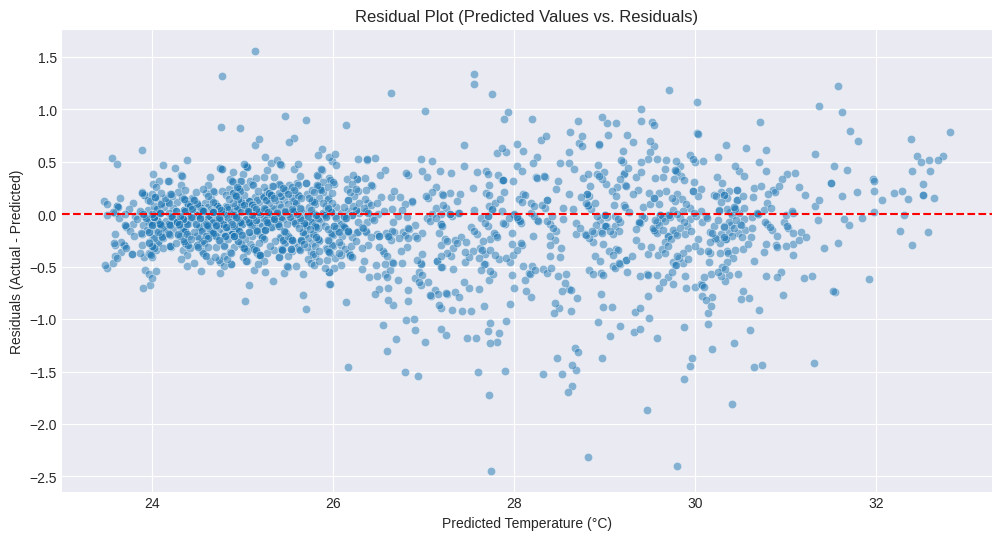

In [ ]:
# Calculate the residuals
residuals = y_test - y_pred

# Create the residual plot
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')

plt.title('Residual Plot (Predicted Values vs. Residuals)')
plt.xlabel('Predicted Temperature (°C)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()

Model Performance on Test Set:
MAE: 0.2989
RMSE: 0.4247
R² Score: 0.9661


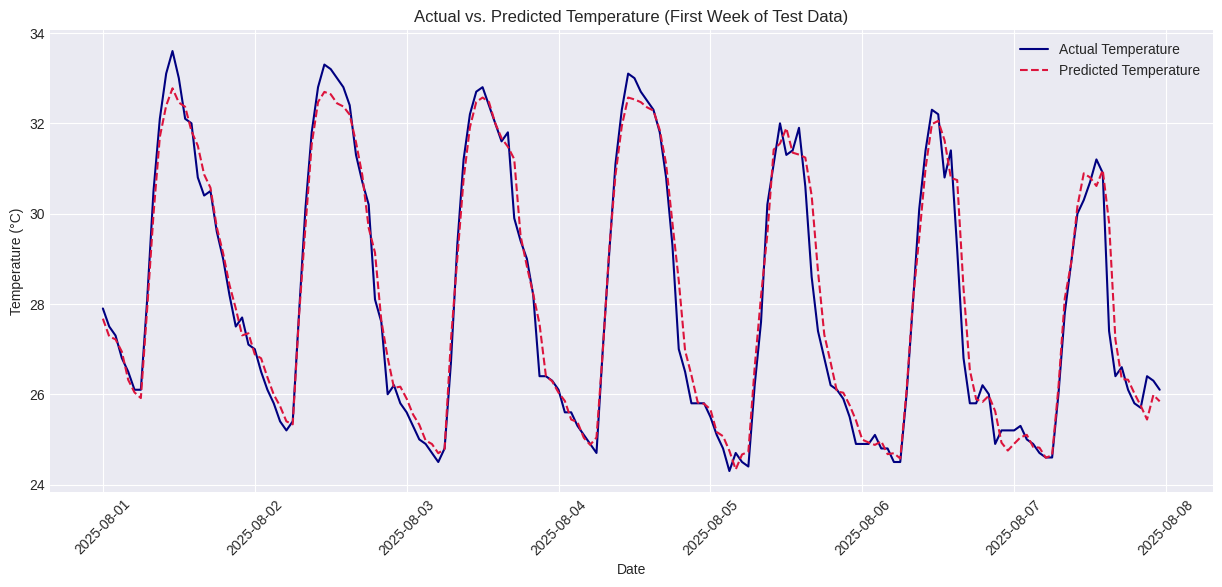

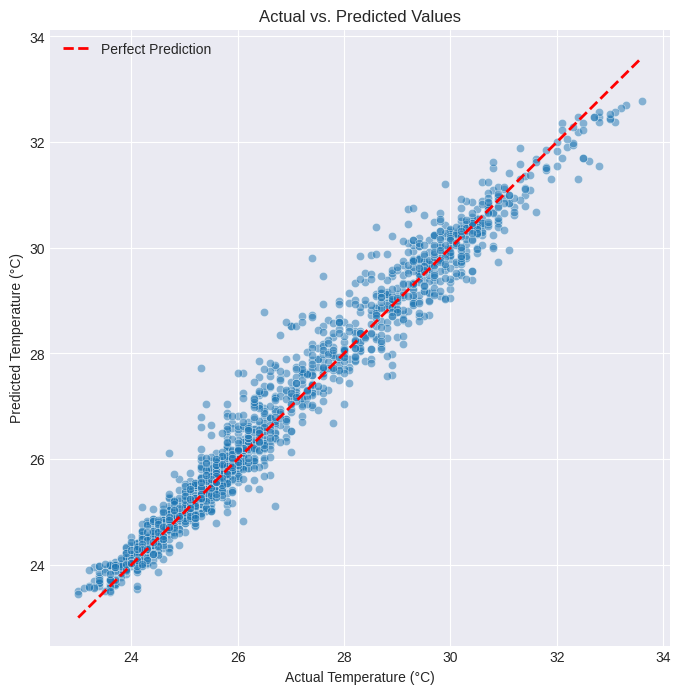

In [ ]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Model Performance on Test Set:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


# 1. Line Plot: Actual vs. Predicted values over time
plt.figure(figsize=(15, 6))
plt.plot(y_test.index[:168], y_test.values[:168], label='Actual Temperature', color='navy')
plt.plot(y_test.index[:168], y_pred[:168], label='Predicted Temperature', color='crimson', linestyle='--')
plt.title('Actual vs. Predicted Temperature (First Week of Test Data)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# 2. Scatter Plot: Actual vs. Predicted
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Temperature (°C)')
plt.ylabel('Predicted Temperature (°C)')
plt.legend()
plt.show()

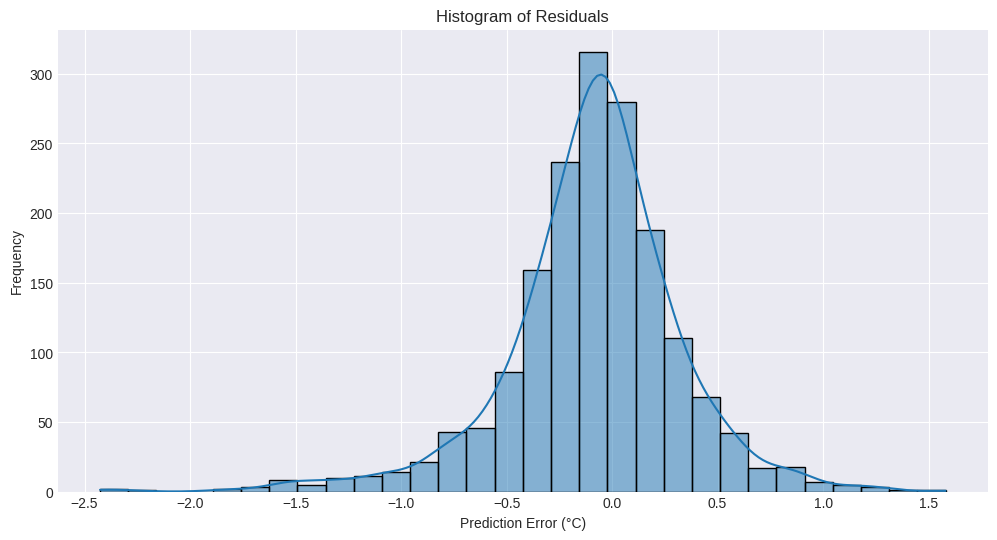

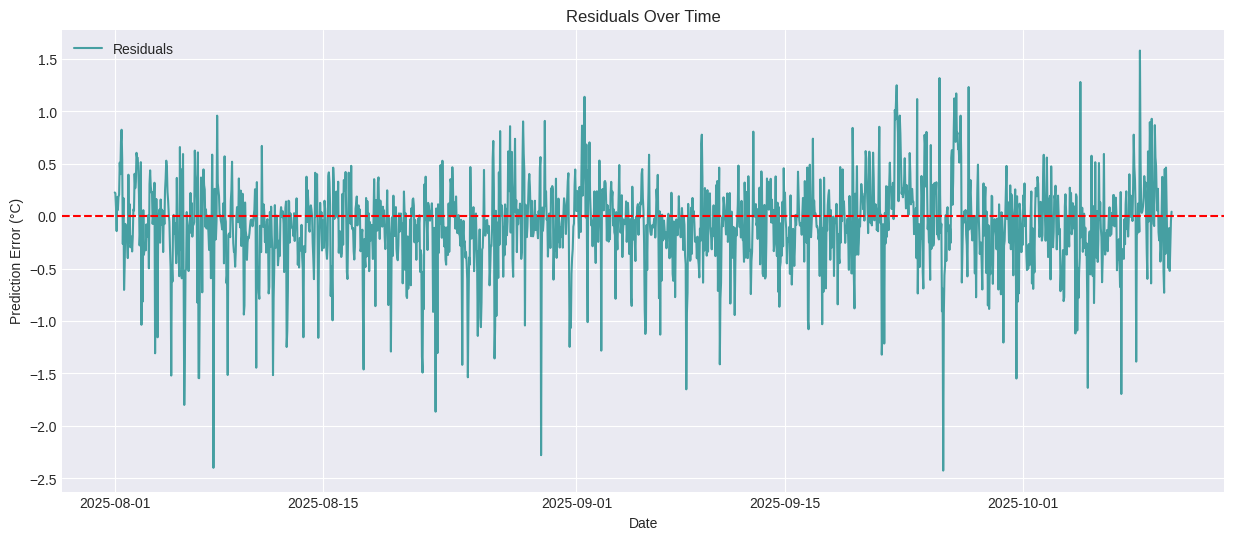

In [ ]:
# Calculate the residuals
residuals = y_test - y_pred

# 1. histogram of the residuals
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Prediction Error (°C)')
plt.ylabel('Frequency')
plt.show()

# 2. Plot residuals over time
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, residuals, label='Residuals', color='teal', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Prediction Error (°C)')
plt.legend()
plt.show()

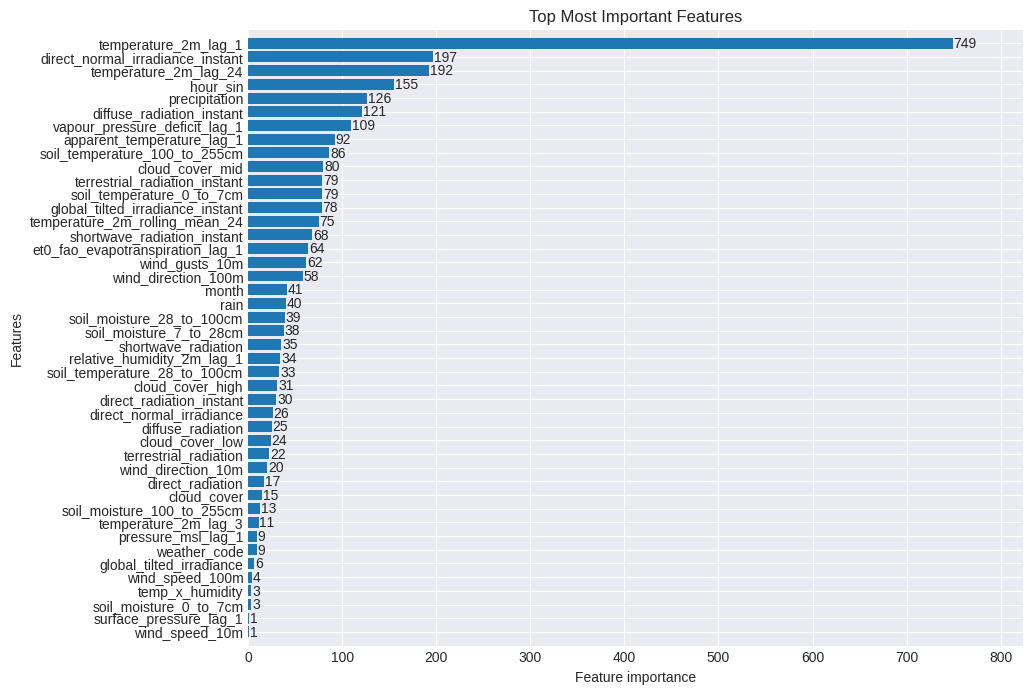

In [ ]:
  # feature importance
lgb.plot_importance(model, height=0.8, max_num_features=60, figsize=(10, 8))
plt.title('Top Most Important Features')
plt.show()

# Prediction within the trained/tested dataset. (Comparison)

In [ ]:
def predict_for_date(target_date, full_dataset_df, model):
    """
    Predicts the temperature for every hour of a specific date and compares to actual values.

    Args:
        target_date (str or pd.Timestamp): The date to predict for (e.g., '2025-03-12').
        full_dataset_df (pd.DataFrame): The complete dataframe with a datetime index
                                        containing data up to the target date.
        model: The trained LightGBM model.

    Returns:
        pd.DataFrame: A DataFrame with actual and predicted temperatures for each hour of the date.
    """
    target_date = pd.to_datetime(target_date).date()
    start_time = pd.to_datetime(target_date)
    end_time = start_time + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)

    hourly_predictions = []
    actual_values = []
    timestamps = pd.date_range(start=start_time, end=end_time, freq='h')

    cleaned_full_dataset_df = full_dataset_df.copy()
    cleaned_full_dataset_df.drop(['city_name', 'snow_depth', 'snowfall'], axis=1, errors='ignore', inplace=True)
    cleaned_full_dataset_df.ffill(inplace=True)


    for current_time in timestamps:
        history_start_time = current_time - pd.Timedelta(hours=30)
        historical_data = cleaned_full_dataset_df.loc[history_start_time:current_time].copy()

        if historical_data.empty or current_time not in historical_data.index:
            print(f"Warning: Not enough historical data available for {current_time}. Skipping prediction.")
            hourly_predictions.append(None)
            actual_values.append(None)
            continue

        data_with_features = create_features(historical_data, target_variable='temperature_2m')

        prediction_input = data_with_features.loc[[current_time]]

        prediction_input = prediction_input.drop('temperature_2m', axis=1)
        predicted_value = model.predict(prediction_input)[0]
        hourly_predictions.append(predicted_value)

        # Get the actual value for comparison
        if current_time in cleaned_full_dataset_df.index:
          actual_value = cleaned_full_dataset_df.loc[current_time]['temperature_2m']
          actual_values.append(actual_value)
        else:
          actual_values.append(None)


    results_df = pd.DataFrame({
        'Actual Temperature': actual_values,
        'Predicted Temperature': hourly_predictions
    }, index=timestamps)

    return results_df

In [ ]:
original_df = pd.read_csv(file_path, parse_dates=['datetime'], index_col='datetime')


# Define the specific date you want to predict for
target_date = '2025-09-24'

# Use the function to get the hourly predictions and actual values
hourly_comparison = predict_for_date(target_date, original_df, loaded_model)

hourly_comparison['Predicted Temperature'] = hourly_comparison['Predicted Temperature'].round(2)

# Display the results
print(f"Hourly Actual vs. Predicted Temperature for {target_date}:")
display(hourly_comparison)

Hourly Actual vs. Predicted Temperature for 2025-09-24:


,Actual Temperature,Predicted Temperature
2025-09-24 00:00:00,25.6,25.89
2025-09-24 01:00:00,25.0,25.70
2025-09-24 02:00:00,24.8,25.18
2025-09-24 03:00:00,24.6,24.95
2025-09-24 04:00:00,25.0,24.76
2025-09-24 05:00:00,25.0,25.02
2025-09-24 06:00:00,24.6,25.09
2025-09-24 07:00:00,26.3,26.79
2025-09-24 08:00:00,27.8,27.84
2025-09-24 09:00:00,29.1,28.70


# Prediction outside the dataset. (Next 24 hours?)

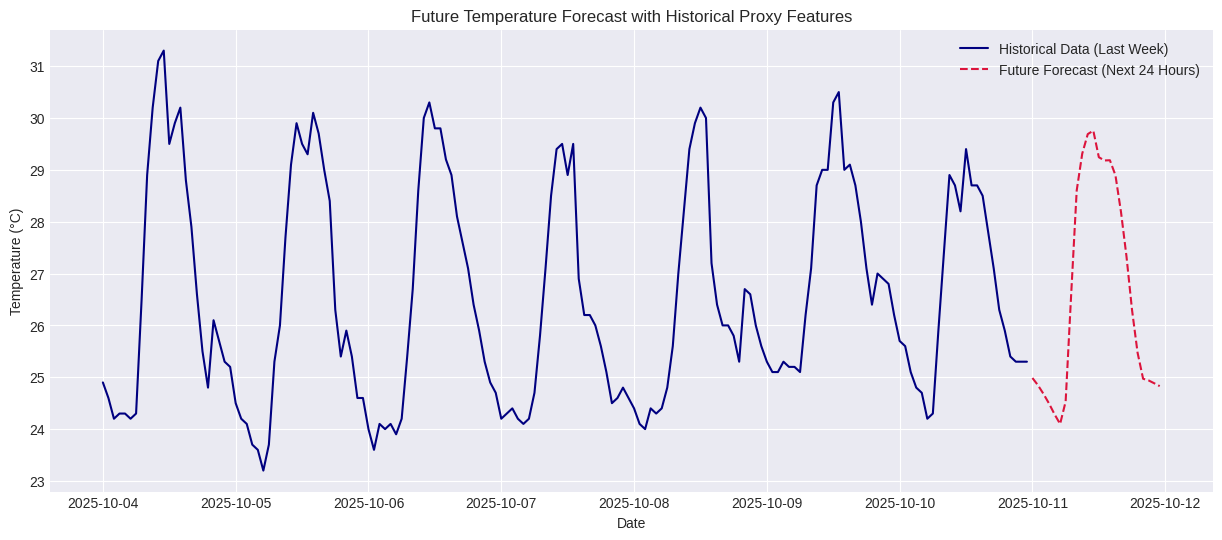

Forecast for the next 24 hours:
2025-10-11 00:00:00    24.99
2025-10-11 01:00:00    24.85
2025-10-11 02:00:00    24.68
2025-10-11 03:00:00    24.49
2025-10-11 04:00:00    24.28
2025-10-11 05:00:00    24.10
2025-10-11 06:00:00    24.53
2025-10-11 07:00:00    26.60
2025-10-11 08:00:00    28.60
2025-10-11 09:00:00    29.31
2025-10-11 10:00:00    29.69
2025-10-11 11:00:00    29.76
2025-10-11 12:00:00    29.24
2025-10-11 13:00:00    29.18
2025-10-11 14:00:00    29.18
2025-10-11 15:00:00    28.90
2025-10-11 16:00:00    28.19
2025-10-11 17:00:00    27.33
2025-10-11 18:00:00    26.30
2025-10-11 19:00:00    25.47
2025-10-11 20:00:00    24.97
2025-10-11 21:00:00    24.94
2025-10-11 22:00:00    24.88
2025-10-11 23:00:00    24.83
Freq: h, dtype: float64


In [ ]:
def create_time_features_for_row(row):
    time_index = row.index
    row['hour'] = time_index.hour
    row['dayofweek'] = time_index.dayofweek
    row['month'] = time_index.month
    row['dayofyear'] = time_index.dayofyear
    row['hour_sin'] = np.sin(2 * np.pi * time_index.hour / 24.0)
    row['hour_cos'] = np.cos(2 * np.pi * time_index.hour / 24.0)
    return row

def forecast_future_refactored(model, full_dataset_df, last_known_data, n_hours=48):
    future_predictions = []
    current_data = last_known_data.copy()

    # Clean the full dataset just once at the start
    cleaned_full_dataset_df = full_dataset_df.copy()
    cleaned_full_dataset_df.drop(['city_name', 'snow_depth', 'snowfall'], axis=1, errors='ignore', inplace=True)
    cleaned_full_dataset_df.ffill(inplace=True)

    for i in range(n_hours):
        # 1. Define the next timestamp and get historical proxy data
        next_timestamp = current_data.index[-1] + pd.Timedelta(hours=1)
        history_lookup_time = next_timestamp - pd.Timedelta(days=7)

        try:
            # Start with the features from one week ago
            next_row = cleaned_full_dataset_df.loc[[history_lookup_time]].copy()
            next_row.index = [next_timestamp]
        except KeyError:
            # Fallback if historical data is missing
            next_row = current_data.iloc[[-1]].copy()
            next_row.index = [next_timestamp]

        # 2. Add all static (time-based) features
        next_row = create_time_features_for_row(next_row)

        # 3. Manually calculate recursive (lag/rolling) features
        next_row[f'{TARGET}_lag_1'] = current_data[TARGET].values[-1]
        next_row[f'{TARGET}_lag_3'] = current_data[TARGET].values[-3]
        next_row[f'{TARGET}_lag_24'] = current_data[TARGET].values[-24]
        next_row[f'{TARGET}_rolling_mean_24'] = pd.concat([current_data[TARGET].tail(23), pd.Series([current_data[TARGET].values[-1]])]).mean()

        # 4. Make the prediction
        features_for_pred = next_row.drop(TARGET, axis=1, errors='ignore')
        features_for_pred = features_for_pred.reindex(columns=model.feature_name_, fill_value=0)

        next_pred = model.predict(features_for_pred)[0]

        # 5. Store prediction and update data for the next loop
        future_predictions.append(next_pred)
        next_row[TARGET] = next_pred
        current_data = pd.concat([current_data, next_row])

    return pd.Series(future_predictions, index=pd.date_range(start=last_known_data.index[-1] + pd.Timedelta(hours=1), periods=n_hours, freq='h'))

original_df = pd.read_csv(file_path, parse_dates=['datetime'], index_col='datetime')

# Define the number of hours to forecast
n_hours_to_forecast = 24 # Predict the next 'x' hours. MODIFY TO FORECAST/PREDICT 'x' HOURS

# Generate the forecast for the next 24 hours
future_forecast_h = forecast_future_refactored(
    model=loaded_model,
    full_dataset_df=original_df,
    last_known_data=df_features.iloc[-24:], # Start with the last 24 hours of feature-engineered data
    n_hours=n_hours_to_forecast
)


plt.figure(figsize=(15, 6))
# Plot the last week of historical data from the feature-engineered dataframe
plt.plot(df_features[TARGET].iloc[-168:], label='Historical Data (Last Week)', color='navy')
# Plot the future forecast
plt.plot(future_forecast_h, label=f'Future Forecast (Next {n_hours_to_forecast} Hours)', color='crimson', linestyle='--')
plt.title('Future Temperature Forecast with Historical Proxy Features')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

print(f"Forecast for the next {n_hours_to_forecast} hours:")
print(future_forecast_h.round(2)) # Round the future_forecast_h to 2 decimal places

# **EVALUATE IF MODEL IS OVERFIT USING VALIDATION SET**

In [ ]:
# make predictions
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

# training metrics
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)
# Validation set metrics
mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
r2_val = r2_score(y_val, y_pred_val)

mae_difference = mae_val - mae_train
rmse_difference = rmse_val - rmse_train
mae_percent = (mae_difference / mae_val) * 100
rmse_percent = (rmse_difference / rmse_val) * 100

# Table
print("    Model Performance Comparison")
print(f"Metric      | Training Set | Val Set")
print(f"--------------------------------------")
print(f"MAE         | {mae_train:<12.4f} | {mae_val:<12.4f}")
print(f"RMSE        | {rmse_train:<12.4f} | {rmse_val:<12.4f}")
print(f"R² Score    | {r2_train:<12.4f} | {r2_val:<12.4f}")
print("\n              Val - Train  | Percent (%)")
print(f"MAE Gap     | {mae_difference:<12.4f} | {mae_percent:<12.2f}%")
print(f"RMSE Gap    | {rmse_difference:<12.4f} | {rmse_percent:<12.2f}%")


    Model Performance Comparison
Metric      | Training Set | Val Set
--------------------------------------
MAE         | 0.2730       | 0.3040      
RMSE        | 0.3762       | 0.4335      
R² Score    | 0.9733       | 0.9663      

              Val - Train  | Percent (%)
MAE Gap     | 0.0310       | 10.21       %
RMSE Gap    | 0.0573       | 13.21       %


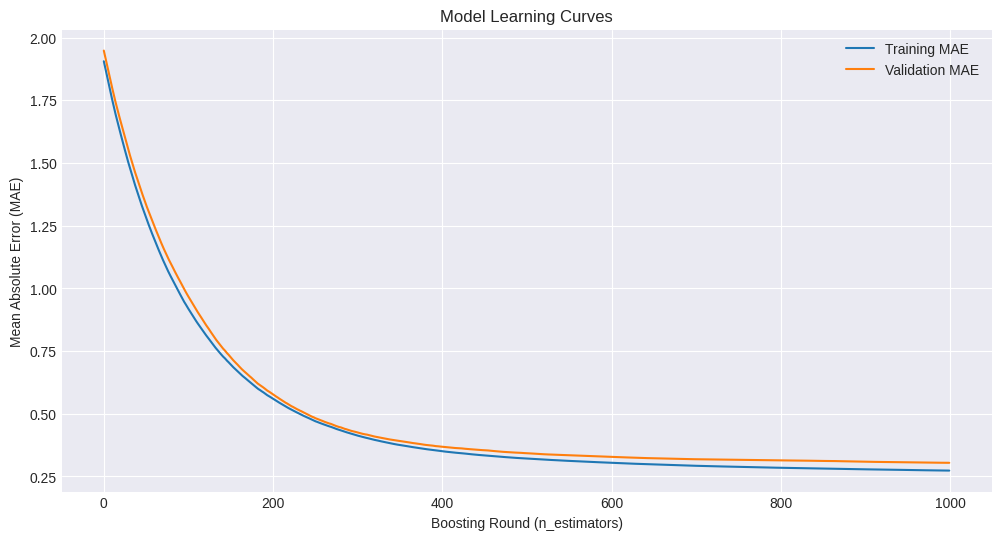

In [ ]:
# Retrieve the evaluation results from the model's history
results = model.evals_result_

# Plot the learning curves
plt.figure(figsize=(12, 6))
plt.plot(results['training']['l1'], label='Training MAE')
plt.plot(results['valid_1']['l1'], label='Validation MAE')
plt.title('Model Learning Curves')
plt.xlabel('Boosting Round (n_estimators)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.show()

# **Final Evaluation using TEST SET**

In [ ]:
# make predictions
y_pred_train = model.predict(X_train)

# training metrics
mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

mae_difference = mae - mae_train
rmse_difference = rmse - rmse_train
mae_percent = (mae_difference / mae) * 100
rmse_percent = (rmse_difference / rmse) * 100

# Table
print("    Model Performance Comparison")
print(f"Metric      | Training Set | Test Set")
print(f"--------------------------------------")
print(f"MAE         | {mae_train:<12.4f} | {mae:<12.4f}")
print(f"RMSE        | {rmse_train:<12.4f} | {rmse:<12.4f}")
print(f"R² Score    | {r2_train:<12.4f} | {r2:<12.4f}")
print("\n              Test - Train | Percent (%)")
print(f"MAE Gap     | {mae_difference:<12.4f} | {mae_percent:<12.2f}%")
print(f"RMSE Gap    | {rmse_difference:<12.4f} | {rmse_percent:<12.2f}%")

    Model Performance Comparison
Metric      | Training Set | Test Set
--------------------------------------
MAE         | 0.2730       | 0.2989      
RMSE        | 0.3762       | 0.4247      
R² Score    | 0.9733       | 0.9661      

              Test - Train | Percent (%)
MAE Gap     | 0.0259       | 8.67        %
RMSE Gap    | 0.0485       | 11.43       %
